Reference
* https://lazyprogrammer.me/bayes-classifier-and-naive-bayes-tutorial-using/
* https://www.twblogs.net/a/5c9109aabd9eee35fc1579bc
* https://blog.csdn.net/qq_31584013/article/details/88543933

$$ \\
\textrm{Paremeter} \, \theta, \, \textrm{Data} \, D \\
Posterior=\displaystyle\frac{Likelihood\times Prior}{Evidence} \\
P(\theta|D)=\displaystyle\frac{P(D|\theta)P(\theta)}{P(D)}$$

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from math import exp, sqrt, pi, log

# For both
digit_class = [[i]for i in range(10)]
prior = [ _ for i in range(10)]

# For discrete
bin_count = [ [ [ 10**-6 for _ in range(32)] for _ in range(28*28)] for _ in range(10)]
posterior_dis = [ [ []for _ in range(10)] for _ in range(10000)]

# For continuous
mean = [ [ []for _ in range(28*28)] for _ in range(10)]
var = [ [ []for _ in range(28*28)] for _ in range(10)]
posterior = [ [ []for _ in range(10)] for _ in range(10000)]

In [2]:
class ubyte_file():
    def __init__(self, filename):
        self.filename = filename
        self.data = []
        
    def read_images(self):
        with open(self.filename, "rb") as f:
            
            # magic number
            byte = f.read(4)
            #print(int.from_bytes(byte,byteorder='big'))
        
            # number of imgs
            byte = f.read(4)
            self.n_images = int.from_bytes(byte,byteorder='big')
        
            # number of rows
            byte = f.read(4)
            self.n_rows = int.from_bytes(byte,byteorder='big')
    
            # number of columns
            byte = f.read(4)
            self.n_cols = int.from_bytes(byte,byteorder='big')
        
            # data
            for i in range(self.n_images):
                byte = f.read(self.n_rows * self.n_cols)
                #print(byte)
                #print(int.from_bytes(byte,byteorder='big'))
                self.data.append(byte)
            
            #print(len(self.data))
            
    def read_labels(self):
        with open(self.filename, "rb") as f:
            
            # magic number
            byte = f.read(4)
            #print(int.from_bytes(byte,byteorder='big'))
        
            # number of imgs
            byte = f.read(4)
            self.n_images = int.from_bytes(byte,byteorder='big')
        
            # data
            for i in range(self.n_images):
                byte = f.read(1)
                #print(byte)
                #print(int.from_bytes(byte,byteorder='big'))
                self.data.append(byte)
            
            #print(len(self.data))
            
            
  

In [3]:
train_images = ubyte_file("train-images.idx3-ubyte")
train_images.read_images()
    
train_labels = ubyte_file("train-labels.idx1-ubyte")
train_labels.read_labels()
    
test_images = ubyte_file("t10k-images.idx3-ubyte")
test_images.read_images()
    
test_labels = ubyte_file("t10k-labels.idx1-ubyte")
test_labels.read_labels()

In [4]:
def plot_image(byte):
        
    image = np.zeros((28,28))
    for i in range(28):
        for j in range(28):
            image[i,j] = byte[i*28 + j]
                
    plt.imshow(image, cmap='gray')

In [5]:
# Separate images by class
def separate_images_by_class():
    for i in range(len(train_labels.data)):
        digit_class[int.from_bytes(train_labels.data[i], byteorder='big')].append(i)
    #print(digit_class[0])
    
    
# Prior
def Prior():
    for i in range(10):
        prior[i] = (len(digit_class[i])-1) / 60000
    #print(prior)
    
    
# Normalize
def normalize(list):
    return [i/sum(list) for i in list]

In [6]:
# Bin count
def Bin_count():
    
    for i in range(10): # i: digit
        #print(i)
        for j in range(28*28): # j: pixel
            k = 1
            while k < len(digit_class[i]): # k: image
                pixel = train_images.data[digit_class[i][k]][j]
                #for b in range(32): # b: bin
                #    if b*8<=pixel and pixel<(b+1)*8:
                #        bin_count[i][j][b] += 1
                #        break
                bin_count[i][j][pixel//8] += 1
                k += 1

    #print(digit_class[0])
    #print(bin_count[0][0])
    #print(bin_count[0][128])
    
    
# Likelihood
def likelihood(im_index):
    likeli = [ [ []for _ in range(28*28)] for _ in range(10)]
    
    for i in range(10): # i: digit
        for j in range(28*28): # j: pixel
            pixel = test_images.data[im_index][j]
            pixel_belongs_to_bin = -1
            #for k in range(32): # k: bin
            #    if k*8<=pixel and pixel<(k+1)*8:
            #        pixel_belongs_to_bin = k
            #        break
            likeli[i][j] = bin_count[i][j][pixel//8] / (len(digit_class[i])-1)
    #print(gauss[0])
    return likeli

#a = likelihood(0)
#print(len(a[0]))


# Posterior for discrete
def Posterior_dis():

    for i in range(10000): # i: test image index
        #print(i)
        likeli = likelihood(i)
        for j in range(10): # j: digit
            s = 0
            for k in range(28*28): # k:pixel
                s += log(likeli[j][k])
            posterior_dis[i][j] = s + log(prior[j])

    #print(posterior_dis[0])
    #print(posterior_dis[1])

In [7]:
# Output for discrete
def Output_dis():
    error_count = 0

    # 1. Posterior, prediction and true label
    for i in range(10000): # i: test image index
        print("Posterior (in log scale):")
        for j in range(10): # j: digit
            print("{}: {}".format(j, normalize(posterior_dis[i])[j]))
        predict = np.argmin(normalize(posterior_dis[i]))
        true_label = int.from_bytes(test_labels.data[i], byteorder='big')
        print("Prediction: {}, Ans: {}".format(predict, true_label))
        print()
        if(predict != true_label):
            error_count += 1
            
    # 2. Imagination of numbers
    print("Imagination of numbers in Bayesian classifier:")
    print()
    for i in range(10): # i: digit
        print("{}:".format(i))
        for j in range(28):
            for k in range(28):
                bin_low = 0
                bin_high = 0
                for b in range(16): # b: bin
                    bin_low += bin_count[i][j*28+k][b]
                    bin_high+= bin_count[i][j*28+k][b+16]
                #print(bin_low)
                #print(bin_high)
                if(bin_low > bin_high):
                    print(0,end=' ')
                else:
                    print(1,end=' ')
            print()
        print()

    # 3. Error rate
    print("Error rate: {}".format(error_count/10000))
    

In [8]:
def discrete():
    
    Bin_count()
    
    Posterior_dis()
    
    Output_dis()
    

Variance
$$ \\
Var(X)=\displaystyle\frac{1}{n}\sum_{i=1}^{n}{(x_{i}-\mu)^{2}}$$

Gaussian distribution, 1D

$$\\
\textrm{Parameters: mean}\,\mu, \textrm{variance}\, \sigma^{2}\\
N(x;\mu,\sigma)=\displaystyle\frac{1}{\sqrt{2\pi\sigma^{2}}}exp\big[-\displaystyle\frac{1}{2}(x-\mu)^{2}/\sigma^{2}\big]$$

Gaussian distribution, Dimension D
$$ \\
\textrm{variance}\,\textstyle\sum \\
P(x|c)=\displaystyle\frac{1}{\sqrt{(2\pi)^{D}|\textstyle\sum|}}exp\big(-\displaystyle\frac{1}{2}(x-\mu)^{T}\textstyle\sum^{-1}(x-\mu)\big) \\
logP(x|c)=-\displaystyle\frac{D}{2}ln(2\pi)-\displaystyle\frac{1}{2}ln|\textstyle\sum|-\displaystyle\frac{1}{2}(x-\mu)^{T}\textstyle\sum^{-1}(x-\mu)$$

In [9]:
# Mean
def Mean():

    for i in range(10): # i: digit
        for j in range(28*28): # j: pixel
            #print(j)
            s = 0
            k = 1
            while k < len(digit_class[i]): # k: image
                s += train_images.data[digit_class[i][k]][j]
                k += 1
            mean[i][j] = s / (len(digit_class[i]) -1)
    #print(mean[0])
    #print(mean[1])
    
    
# Variance
def Variance():

    for i in range(10): # i: digit
        for j in range(28*28): # j: pixel
            #print(j)
            s = 0
            k = 1
            while k < len(digit_class[i]): # k: image
                #print(mean[i][j])
                s += (train_images.data[digit_class[i][k]][j] - mean[i][j])**2
                k += 1
            var[i][j] = s / (len(digit_class[i]) -1)
            if var[i][j] <= 10**3:
                var[i][j] = 10**3
    #print(var[0])
    
    
# Gaussian
def gaussian(im_index):
    gauss = [ [ []for _ in range(28*28)] for _ in range(10)]
    
    for i in range(10): # i: digit
        for j in range(28*28): # j: pixel
            gauss[i][j] = -1/2*log(2*pi) - (1/2*log(var[i][j])) - (1/2*(test_images.data[im_index][j] - mean[i][j])**2 / var[i][j])
    #print(gauss[0])
    return gauss
#gaussian(0)


# Posterior for continuous
def Posterior():

    for i in range(10000): # i: test image index
        #print(i)
        gauss = gaussian(i)
        for j in range(10): # j: digit
            s = 0
            for k in range(28*28): # k:pixel
                #print(gaussian(i)[j][k])
                s += (gauss[j][k])
            posterior[i][j] = s + log(prior[j])

    #print(posterior[0])
    #print(posterior[1])
    

In [10]:
# Output
def Output():
    error_count = 0

    # 1. Posterior, prediction and true label
    for i in range(10000): # i: test image index
        print("Posterior (in log scale):")
        for j in range(10): # j: digit
            print("{}: {}".format(j, normalize(posterior[i])[j]))
        predict = np.argmin(normalize(posterior[i]))
        true_label = int.from_bytes(test_labels.data[i], byteorder='big')
        print("Prediction: {}, Ans: {}".format(predict, true_label))
        print()
        if(predict != true_label):
            error_count += 1
    
    # 2. Imagination of numbers
    print("Imagination of numbers in Bayesian classifier:")
    print()
    for i in range(10):
        print("{}:".format(i))
        for j in range(28):
            for k in range(28):
                if(mean[i][j*28+k] < 128):
                    print(0,end=' ')
                else:
                    print(1,end=' ')
            print()
        print()

    # 3. Error rate
    print("Error rate: {}".format(error_count/10000))

In [11]:
# Continuous

def continuous():

    # Mean
    Mean()
    
    # Variance
    Variance()

    # Posterior
    Posterior()
    
    # Output
    Output()


In [12]:
def main():
    print("Input 0 for discrete mode; 1 for continuous mode")
    
    mode = input()
    
    plot_image(test_images.data[0])
    #print(train_images.data[1][126]) 
    #print(train_images.data[1][127]) 
    #print(train_images.data[1][128]) 
    #print(train_images.data[1][129]) 
    #print(train_images.data[1]) 
    
    # Separate images by class
    separate_images_by_class()

    # Prior
    Prior()
    
    if int(mode) == 0:
        discrete()
    else:
        continuous()


Input 0 for discrete mode; 1 for continuous mode
0
Posterior (in log scale):
0: 0.11208702499204914
1: 0.13689337195930193
2: 0.10872616676743424
3: 0.09623688961934611
4: 0.09057560833732131
5: 0.09193332691561582
6: 0.12727303826864858
7: 0.06689545070502484
8: 0.09189688089396517
9: 0.07748224154129287
Prediction: 7, Ans: 7

Posterior (in log scale):
0: 0.09839552240659706
1: 0.11080355409947287
2: 0.07142054913737614
3: 0.08733841637103751
4: 0.10732625522615839
5: 0.0877842058124468
6: 0.08396301867846892
7: 0.13430968912660854
8: 0.09527628900825678
9: 0.123382500133577
Prediction: 2, Ans: 2

Posterior (in log scale):
0: 0.12692313050813125
1: 0.06255685551422749
2: 0.09698773626579633
3: 0.09895400534589398
4: 0.10178335926282729
5: 0.09498240366841519
6: 0.10174921684483415
7: 0.10966537500001543
8: 0.09866169728233322
9: 0.10773622030752558
Prediction: 1, Ans: 1

Posterior (in log scale):
0: 0.07366230611983116
1: 0.16935591217471435
2: 0.09216084429990082
3: 0.091672351183288

Posterior (in log scale):
0: 0.12541852168331324
1: 0.06839007924098303
2: 0.09687505101695125
3: 0.09948848879637794
4: 0.09920371304384688
5: 0.0937596309567494
6: 0.10468478388362638
7: 0.1073951417133284
8: 0.09834372911289567
9: 0.10644086055192784
Prediction: 1, Ans: 1

Posterior (in log scale):
0: 0.09452154773137995
1: 0.11718535930998539
2: 0.07963405214253483
3: 0.08365175328054535
4: 0.10054559538148078
5: 0.08795889146192852
6: 0.10781882365219564
7: 0.122867346006108
8: 0.08611533804971498
9: 0.11970129298412654
Prediction: 2, Ans: 2

Posterior (in log scale):
0: 0.10818143265508753
1: 0.13059348954931455
2: 0.09721758812921133
3: 0.08998058121541558
4: 0.09373459651972595
5: 0.09196473411360737
6: 0.11327290163089303
7: 0.09644553861051836
8: 0.08484392427340266
9: 0.09376521330282353
Prediction: 8, Ans: 8

Posterior (in log scale):
0: 0.124142425642054
1: 0.10775506241353076
2: 0.09946140534160974
3: 0.10013202493495207
4: 0.0874396076169595
5: 0.09389720433079107
6: 0.0

2: 0.10201194608173983
3: 0.08221647464022248
4: 0.08752756829427898
5: 0.09657013483555171
6: 0.11593549968895293
7: 0.06510350036817725
8: 0.09884565315036055
9: 0.0951498955345924
Prediction: 7, Ans: 7

Posterior (in log scale):
0: 0.10081268122177514
1: 0.12306207338555665
2: 0.10763547350534163
3: 0.1070483660153827
4: 0.09162246161703408
5: 0.08332908734206772
6: 0.1078795195621111
7: 0.09341042801164028
8: 0.08943647519834508
9: 0.09576343414074559
Prediction: 5, Ans: 5

Posterior (in log scale):
0: 0.11357157848347918
1: 0.1452889482322281
2: 0.10114790618166025
3: 0.09737912710310491
4: 0.07984456181175296
5: 0.09243797794562413
6: 0.09996847903482158
7: 0.09076634958383478
8: 0.09519389006369824
9: 0.084401181559796
Prediction: 4, Ans: 4

Posterior (in log scale):
0: 0.0815231108152309
1: 0.1486080889424865
2: 0.09364546634916827
3: 0.08981971385661318
4: 0.097127239087216
5: 0.08699176245617053
6: 0.09241780634438691
7: 0.11579756127562492
8: 0.09194071127067054
9: 0.1021285

0: 0.08902986869432877
1: 0.14187844289073367
2: 0.07043499294125519
3: 0.08394822957200423
4: 0.09339050377893762
5: 0.08851059125113489
6: 0.0789835469655234
7: 0.13955847341708108
8: 0.0943153549589683
9: 0.11994999553003287
Prediction: 2, Ans: 2

Posterior (in log scale):
0: 0.1163453060778087
1: 0.0989450556854794
2: 0.1087594800000507
3: 0.0965378507812411
4: 0.09607824557465064
5: 0.08439102258052464
6: 0.12379224544845685
7: 0.09506506368324408
8: 0.0884937408043507
9: 0.09159198936419324
Prediction: 5, Ans: 5

Posterior (in log scale):
0: 0.13035467676965284
1: 0.07721198363711844
2: 0.10064937863082715
3: 0.09691510315903468
4: 0.09904000200972898
5: 0.09253542409557598
6: 0.09813655957715248
7: 0.10851996168505687
8: 0.09418612377029192
9: 0.10245078666556072
Prediction: 1, Ans: 1

Posterior (in log scale):
0: 0.10048387223147424
1: 0.11885668514008858
2: 0.06370145205859606
3: 0.08691480761846417
4: 0.09926977146234962
5: 0.09462995753022496
6: 0.07742757083633178
7: 0.1291

Prediction: 5, Ans: 5

Posterior (in log scale):
0: 0.12648126164136037
1: 0.068921416486058
2: 0.10167662779160698
3: 0.09584813422653414
4: 0.10148645584045485
5: 0.0919497625253649
6: 0.10066992605917882
7: 0.1049172232366219
8: 0.100219326040684
9: 0.10782986615213608
Prediction: 1, Ans: 1

Posterior (in log scale):
0: 0.06510871031952473
1: 0.18948626170819
2: 0.08560959048678841
3: 0.09730523867818958
4: 0.0943003399675705
5: 0.08356584560795378
6: 0.09213269884229128
7: 0.09941835487625107
8: 0.09026266825320718
9: 0.10281029126003353
Prediction: 0, Ans: 0

Posterior (in log scale):
0: 0.10277643259460212
1: 0.127232957493076
2: 0.08881629776750205
3: 0.09643530849471485
4: 0.09491412568529324
5: 0.09190819411603661
6: 0.07759090762605152
7: 0.11141256330582497
8: 0.09988006316703547
9: 0.10903314974986324
Prediction: 6, Ans: 6

Posterior (in log scale):
0: 0.11231641183223116
1: 0.15634404793650833
2: 0.09574385579311868
3: 0.09631456562850127
4: 0.07810697166394279
5: 0.092714

7: 0.11514371717783832
8: 0.09496584704972584
9: 0.12393732308328669
Prediction: 3, Ans: 3

Posterior (in log scale):
0: 0.1078453471707638
1: 0.1177885018489748
2: 0.11854757991049161
3: 0.09732388941289775
4: 0.08845634777423181
5: 0.0784858024876501
6: 0.1385076441003645
7: 0.0856961118591026
8: 0.08372604225113815
9: 0.08362273318438478
Prediction: 5, Ans: 5

Posterior (in log scale):
0: 0.10908469619221348
1: 0.0950786240928744
2: 0.09280961197168656
3: 0.09662127484614429
4: 0.10203565262726334
5: 0.09422500741571843
6: 0.1157447570578602
7: 0.10753638215747374
8: 0.08568829199645293
9: 0.10117570164231252
Prediction: 8, Ans: 8

Posterior (in log scale):
0: 0.11610478610843936
1: 0.10110789857284772
2: 0.09286802928138228
3: 0.09387137301006773
4: 0.1007818435034275
5: 0.09272846409330286
6: 0.08284313830113164
7: 0.12170464989204145
8: 0.09264125779696021
9: 0.10534855944039918
Prediction: 6, Ans: 6

Posterior (in log scale):
0: 0.08532873651501546
1: 0.12029552944686428
2: 0.09

Posterior (in log scale):
0: 0.09093508712245313
1: 0.18228376626720189
2: 0.08265403893916888
3: 0.0972954267911661
4: 0.08157996623917091
5: 0.0925320631646838
6: 0.10987396470833233
7: 0.0865288688154948
8: 0.09773623193550061
9: 0.07858058601682769
Prediction: 9, Ans: 9

Posterior (in log scale):
0: 0.10290604179836205
1: 0.11427937916734708
2: 0.08240684983453689
3: 0.09655105853862785
4: 0.09554004326309043
5: 0.09470438554146351
6: 0.09369952436661687
7: 0.12333624328156627
8: 0.0858362895328536
9: 0.11074018467553533
Prediction: 2, Ans: 2

Posterior (in log scale):
0: 0.10056567262053699
1: 0.13685652056244096
2: 0.09748877677542711
3: 0.07555833055109931
4: 0.09859937116527662
5: 0.08433694995591627
6: 0.11806819501358833
7: 0.10271289777532101
8: 0.08933135669116625
9: 0.09648192888922733
Prediction: 3, Ans: 3

Posterior (in log scale):
0: 0.1039118093659689
1: 0.11167773150320959
2: 0.0895616083105522
3: 0.07408175667328208
4: 0.10034935234134403
5: 0.08518878850997186
6: 0.

6: 0.09419114557575421
7: 0.12543277291434002
8: 0.08878005260937277
9: 0.11830892975199903
Prediction: 3, Ans: 5

Posterior (in log scale):
0: 0.09590569806992177
1: 0.13980211082965463
2: 0.09204155559203343
3: 0.09406899400591628
4: 0.10137287086965353
5: 0.08757815749762288
6: 0.1275182454691505
7: 0.08554747240099633
8: 0.08582822500179448
9: 0.090336670263256
Prediction: 7, Ans: 7

Posterior (in log scale):
0: 0.09342615372856534
1: 0.12939281542064127
2: 0.08813155603637265
3: 0.10142068823100196
4: 0.09371662225714712
5: 0.08785457035965412
6: 0.06845179626236726
7: 0.1259084026378138
8: 0.10189403778578267
9: 0.10980335728065388
Prediction: 6, Ans: 6

Posterior (in log scale):
0: 0.10352251841483887
1: 0.1508694216363287
2: 0.09712266677611378
3: 0.09653813788466444
4: 0.08739161369702877
5: 0.09558098236287998
6: 0.10837203270135035
7: 0.07443003287037127
8: 0.0989084730868432
9: 0.08726412056958065
Prediction: 7, Ans: 7

Posterior (in log scale):
0: 0.1258727738030036
1: 0.1

6: 0.11399920557502952
7: 0.09214626022369635
8: 0.08898433275860018
9: 0.08935423949078425
Prediction: 8, Ans: 7

Posterior (in log scale):
0: 0.12100541412251645
1: 0.11606462164823242
2: 0.10032686612302523
3: 0.09835725052461682
4: 0.08745260442577625
5: 0.09541305642856461
6: 0.10283440137459318
7: 0.0975505570014189
8: 0.09371868642120895
9: 0.08727654193004711
Prediction: 9, Ans: 4

Posterior (in log scale):
0: 0.089987219067441
1: 0.13816076748723558
2: 0.08635461505995828
3: 0.08974279811198557
4: 0.09549073813456153
5: 0.08297700304986287
6: 0.08536647554901482
7: 0.13358508674386257
8: 0.08391292371796338
9: 0.11442237307811452
Prediction: 5, Ans: 5

Posterior (in log scale):
0: 0.09337226702572697
1: 0.1661462653846447
2: 0.08798939445523471
3: 0.09650736924483858
4: 0.08279081398138712
5: 0.09214546876353241
6: 0.10417528492345007
7: 0.10067725141629337
8: 0.0904433464015179
9: 0.08575253840337414
Prediction: 4, Ans: 9

Posterior (in log scale):
0: 0.08679237695737611
1: 0

8: 0.08819343451605774
9: 0.10367570734282852
Prediction: 0, Ans: 0

Posterior (in log scale):
0: 0.07074517912944708
1: 0.16801156846619844
2: 0.08799036842501767
3: 0.09258294321386584
4: 0.09148765902210915
5: 0.084069060180094
6: 0.09087526646228804
7: 0.1199413724805704
8: 0.08972368800135166
9: 0.10457289461905775
Prediction: 0, Ans: 0

Posterior (in log scale):
0: 0.10254875690569391
1: 0.13292420858735124
2: 0.08867983618950212
3: 0.09458920635124898
4: 0.09105260687926917
5: 0.09414904919394616
6: 0.08156032583305409
7: 0.11075135818919657
8: 0.0998358673264747
9: 0.10390878454426297
Prediction: 6, Ans: 6

Posterior (in log scale):
0: 0.10251614211375597
1: 0.11985227183770371
2: 0.08634024869129489
3: 0.07444127892967005
4: 0.0943997058317164
5: 0.08813246677979684
6: 0.10443291935629674
7: 0.11294398214471359
8: 0.09413302304325254
9: 0.12280796127179931
Prediction: 3, Ans: 3

Posterior (in log scale):
0: 0.10312575734136006
1: 0.1339384670038696
2: 0.10982621446956842
3: 0.

6: 0.1154460211193698
7: 0.09970827956089161
8: 0.09856218549070439
9: 0.09842328006143801
Prediction: 1, Ans: 1

Posterior (in log scale):
0: 0.07938224368646665
1: 0.16671835702447885
2: 0.0856903425610616
3: 0.0875604409648059
4: 0.09318460747578174
5: 0.08561494727574268
6: 0.094279612658538
7: 0.11251233009392261
8: 0.09101377397228626
9: 0.10404334428691567
Prediction: 0, Ans: 0

Posterior (in log scale):
0: 0.10648087367487605
1: 0.1569715160598795
2: 0.08590327568243485
3: 0.08213823726983353
4: 0.08645484598977492
5: 0.10013515565803789
6: 0.10718313655535999
7: 0.08775185776039846
8: 0.09256272972108281
9: 0.09441837162832209
Prediction: 3, Ans: 2

Posterior (in log scale):
0: 0.09377197414208092
1: 0.1538808730742353
2: 0.10712275477367153
3: 0.09476819500058388
4: 0.08414029930277772
5: 0.07961411271415969
6: 0.11276058397783073
7: 0.09421916535108688
8: 0.0886888739719779
9: 0.09103316769159538
Prediction: 5, Ans: 5

Posterior (in log scale):
0: 0.09917230567985842
1: 0.13

8: 0.09755983518693427
9: 0.11391150571577859
Prediction: 6, Ans: 6

Posterior (in log scale):
0: 0.12280104340482433
1: 0.12897362584721553
2: 0.11358822049809343
3: 0.09897463706792599
4: 0.08675564556185533
5: 0.08946386295391245
6: 0.11685809271698494
7: 0.07470855702346874
8: 0.09231952788768331
9: 0.07555678703803587
Prediction: 7, Ans: 7

Posterior (in log scale):
0: 0.11538246721307965
1: 0.10216954200367688
2: 0.08844520148190844
3: 0.09586640469913017
4: 0.1002354592557883
5: 0.09558252002401757
6: 0.08033337101622617
7: 0.1160445272939657
8: 0.09702939177950863
9: 0.10891111523269842
Prediction: 6, Ans: 6

Posterior (in log scale):
0: 0.0956439240009123
1: 0.12518313125958722
2: 0.09553413279715936
3: 0.09191234303419357
4: 0.0977430983891505
5: 0.08935867069512358
6: 0.09060259815271485
7: 0.11603143470365006
8: 0.09244888988340765
9: 0.10554177708410091
Prediction: 5, Ans: 0

Posterior (in log scale):
0: 0.07207268059102159
1: 0.15938394555555743
2: 0.08559373669000646
3: 

4: 0.09300523214334401
5: 0.08169719917104595
6: 0.10270665881582122
7: 0.10639186966891626
8: 0.08523380647469901
9: 0.1034851027068171
Prediction: 0, Ans: 0

Posterior (in log scale):
0: 0.10865448314958133
1: 0.15049808363431136
2: 0.10010987995279624
3: 0.08169908780804655
4: 0.08991387751608329
5: 0.09627503305801091
6: 0.11843916676264446
7: 0.07028240063926625
8: 0.09924155976456338
9: 0.08488642771469622
Prediction: 7, Ans: 7

Posterior (in log scale):
0: 0.1271770571142413
1: 0.07763980821233528
2: 0.0986801727018816
3: 0.09329567198663073
4: 0.104443833190918
5: 0.09280954444298745
6: 0.09992167202885249
7: 0.1071006265747233
8: 0.09605456465828667
9: 0.10287704908914325
Prediction: 1, Ans: 1

Posterior (in log scale):
0: 0.11041421395820207
1: 0.15584354498201536
2: 0.10565134203254349
3: 0.10091077999196897
4: 0.07883604017380046
5: 0.09087792691851894
6: 0.11432503680785504
7: 0.07613399004092364
8: 0.09465103470425003
9: 0.07235609038992209
Prediction: 9, Ans: 9

Posterio

Prediction: 5, Ans: 5

Posterior (in log scale):
0: 0.1174806120314379
1: 0.10100349573434281
2: 0.09609401246913805
3: 0.09745547324030553
4: 0.0934083530710247
5: 0.09339005303222878
6: 0.10940576967986629
7: 0.10722967234201342
8: 0.09161680868985488
9: 0.09291574970978757
Prediction: 8, Ans: 7

Posterior (in log scale):
0: 0.09944574168443562
1: 0.10750385127306335
2: 0.08558932608793032
3: 0.08742526469311084
4: 0.10117314423048918
5: 0.09027630459595896
6: 0.104230022230537
7: 0.12966122449998665
8: 0.08240313719115136
9: 0.11229198351333675
Prediction: 8, Ans: 2

Posterior (in log scale):
0: 0.1035055892305309
1: 0.15932155524329622
2: 0.09390687919257176
3: 0.10064808177811668
4: 0.08187910921262839
5: 0.09290604355849148
6: 0.10334733784526337
7: 0.09143765711001832
8: 0.09305560567464131
9: 0.0799921411544416
Prediction: 9, Ans: 9

Posterior (in log scale):
0: 0.0873186508446538
1: 0.19055655742801875
2: 0.07687017462396797
3: 0.09151303490784392
4: 0.07302484882676377
5: 0.0

Prediction: 7, Ans: 7

Posterior (in log scale):
0: 0.08318382654847177
1: 0.15723927409914737
2: 0.09653741459871255
3: 0.0953526930788823
4: 0.09337057794084164
5: 0.08981215863214732
6: 0.09003321036556823
7: 0.10599136929644483
8: 0.09291977111051644
9: 0.09555970432926757
Prediction: 0, Ans: 0

Posterior (in log scale):
0: 0.10159884195474152
1: 0.10465757088788223
2: 0.10040677996158989
3: 0.09173857277437239
4: 0.09785957061803113
5: 0.08336622240321225
6: 0.09493079686634
7: 0.1256045685293276
8: 0.08967556885573523
9: 0.11016150714876773
Prediction: 5, Ans: 6

Posterior (in log scale):
0: 0.11409479625569147
1: 0.12943397397114997
2: 0.10731314201050056
3: 0.0998254522224048
4: 0.08853690223564477
5: 0.09372182916478923
6: 0.12964284779936516
7: 0.06465487242517555
8: 0.09524190137301712
9: 0.07753428254226119
Prediction: 7, Ans: 7

Posterior (in log scale):
0: 0.09814265508802132
1: 0.15567693040756744
2: 0.09679004766704975
3: 0.09661138113152708
4: 0.0883925029437589
5: 0.0

2: 0.10776033053837486
3: 0.10471314104560694
4: 0.09034326270509303
5: 0.08095708902241365
6: 0.10967473898287562
7: 0.11015588285338127
8: 0.08719972888117994
9: 0.10012047193752724
Prediction: 5, Ans: 5

Posterior (in log scale):
0: 0.09067096247951054
1: 0.13841382020558668
2: 0.09623392133842491
3: 0.09234518335517587
4: 0.09971663793240065
5: 0.09069836199338123
6: 0.09037916334717591
7: 0.10847234505476566
8: 0.09333688002459152
9: 0.09973272426898708
Prediction: 6, Ans: 0

Posterior (in log scale):
0: 0.11197127676738375
1: 0.15196753735830823
2: 0.09549586433564185
3: 0.08150709037982094
4: 0.08842622503227981
5: 0.0972481833547356
6: 0.1203403465641444
7: 0.062840503221358
8: 0.10090832942889928
9: 0.0892946435574281
Prediction: 7, Ans: 7

Posterior (in log scale):
0: 0.10381495767876502
1: 0.15621587822144506
2: 0.09641906030288654
3: 0.09573344464581436
4: 0.07918320215645307
5: 0.09078470841459658
6: 0.09402124000590643
7: 0.10309951779718943
8: 0.09448617256528603
9: 0.08

8: 0.09296994174006691
9: 0.08513704542653783
Prediction: 4, Ans: 4

Posterior (in log scale):
0: 0.06130088643514402
1: 0.19298593333355601
2: 0.07863319699115012
3: 0.0954883890418703
4: 0.09369607796673252
5: 0.08268531240191763
6: 0.08183518831686536
7: 0.11970570536890607
8: 0.08421679017303958
9: 0.10945251997081841
Prediction: 0, Ans: 0

Posterior (in log scale):
0: 0.11403716462471684
1: 0.11260063043963812
2: 0.07459016731706421
3: 0.08322079545095787
4: 0.09403847222132002
5: 0.08997008916429501
6: 0.09619557603117632
7: 0.11486547451273538
8: 0.09431230104434209
9: 0.12616932919375407
Prediction: 2, Ans: 2

Posterior (in log scale):
0: 0.1282815490878765
1: 0.06987733776726701
2: 0.10032946050928215
3: 0.09968788930855993
4: 0.10124030589998531
5: 0.09452501466880159
6: 0.09886517660495864
7: 0.10517755207718135
8: 0.09826852222222184
9: 0.10374719185386568
Prediction: 1, Ans: 1

Posterior (in log scale):
0: 0.0895650137338203
1: 0.13015090799020382
2: 0.09299949530506979
3:

Posterior (in log scale):
0: 0.1271805352830916
1: 0.0668076947218216
2: 0.0955780940031607
3: 0.09660819990607938
4: 0.10282054293330728
5: 0.09573268332811431
6: 0.12049246827482794
7: 0.1037657554692615
8: 0.0896280150430645
9: 0.1013860110372711
Prediction: 1, Ans: 1

Posterior (in log scale):
0: 0.11755740004882051
1: 0.12696475147426806
2: 0.11033966798663025
3: 0.09945368860603725
4: 0.08994625581275069
5: 0.08804695312768643
6: 0.12201047655587184
7: 0.0693597700205242
8: 0.09887111107255757
9: 0.07744992529485312
Prediction: 7, Ans: 7

Posterior (in log scale):
0: 0.0907090081065557
1: 0.1500118736489126
2: 0.08600861645639031
3: 0.09598568162738626
4: 0.0934354050363941
5: 0.09269977532923826
6: 0.07142746340051884
7: 0.12077621426939533
8: 0.09491263224846817
9: 0.10403332987674041
Prediction: 6, Ans: 6

Posterior (in log scale):
0: 0.089503322056496
1: 0.15292226990898244
2: 0.08467846309206319
3: 0.101426961127924
4: 0.09228273048384403
5: 0.09045088687180033
6: 0.06728297

0: 0.10573319656051823
1: 0.14692330306311338
2: 0.0951744577005244
3: 0.10011541246226988
4: 0.0811892557397653
5: 0.09384685392101781
6: 0.10629419081650326
7: 0.09278566580951376
8: 0.0919648494062584
9: 0.08597281452051561
Prediction: 4, Ans: 4

Posterior (in log scale):
0: 0.08763673814569443
1: 0.14384501146973278
2: 0.09958065499140253
3: 0.09090620598636107
4: 0.09770507563891045
5: 0.08161532831313051
6: 0.10205796705480696
7: 0.10453454959601706
8: 0.09031765819612372
9: 0.10180081060782065
Prediction: 5, Ans: 5

Posterior (in log scale):
0: 0.0911022701598731
1: 0.14160199443923754
2: 0.08369542021201594
3: 0.09953932125778817
4: 0.09401736489530238
5: 0.09723199308154001
6: 0.07523382747297931
7: 0.11503323511077056
8: 0.09548200675267758
9: 0.10706256661781545
Prediction: 6, Ans: 6

Posterior (in log scale):
0: 0.10140922234382739
1: 0.16649920132665108
2: 0.10795813945611975
3: 0.08961850365804272
4: 0.08541943038555713
5: 0.08899825772143946
6: 0.12092237164652292
7: 0.0

2: 0.10511339058826268
3: 0.08775842444504056
4: 0.09972138875659045
5: 0.08227540156344569
6: 0.11240845099618275
7: 0.11733209864295194
8: 0.08743518868597074
9: 0.09595329338937193
Prediction: 5, Ans: 5

Posterior (in log scale):
0: 0.11462258166454296
1: 0.1309647927241774
2: 0.10428351448523468
3: 0.09449801989083924
4: 0.08819148055351683
5: 0.08877649035598122
6: 0.09531972101458694
7: 0.09967621512777697
8: 0.09607248346448924
9: 0.08759470071885452
Prediction: 9, Ans: 4

Posterior (in log scale):
0: 0.1302762611491801
1: 0.0697995601734472
2: 0.10595081399239206
3: 0.09630820021875437
4: 0.1033051447914512
5: 0.09393790013773118
6: 0.11191108182295341
7: 0.09731708883585731
8: 0.09577948784967857
9: 0.0954144610285545
Prediction: 1, Ans: 1

Posterior (in log scale):
0: 0.10691172027452497
1: 0.10175756285025345
2: 0.09366214964499428
3: 0.08058200554850858
4: 0.10516944754150996
5: 0.0874952203232677
6: 0.10255597271540567
7: 0.11916572988674447
8: 0.09100652521224588
9: 0.111

Prediction: 4, Ans: 8

Posterior (in log scale):
0: 0.12409953305970509
1: 0.08547535785604532
2: 0.10122997400492907
3: 0.09619299207801625
4: 0.09478369218355794
5: 0.08963621999837736
6: 0.09841996265752369
7: 0.107092873874437
8: 0.09764641449505
9: 0.10542297979235833
Prediction: 1, Ans: 1

Posterior (in log scale):
0: 0.12598630049902854
1: 0.11860962131605113
2: 0.10582641977446625
3: 0.08997199821337243
4: 0.08917652502580438
5: 0.0889048852111194
6: 0.11839785293210713
7: 0.07975263422177789
8: 0.09697323357805816
9: 0.08640052922821458
Prediction: 7, Ans: 7

Posterior (in log scale):
0: 0.12391917251577668
1: 0.14148994447661312
2: 0.10638079370874512
3: 0.0898219640465678
4: 0.0869552573363274
5: 0.08572918084981507
6: 0.11479971563374447
7: 0.07196059848215498
8: 0.10094744642685746
9: 0.07799592652339787
Prediction: 7, Ans: 7

Posterior (in log scale):
0: 0.12618657543496736
1: 0.08654585007549168
2: 0.09952775676238006
3: 0.09331168170739308
4: 0.09872974928668188
5: 0.09

Posterior (in log scale):
0: 0.08908414088032611
1: 0.15861797151979365
2: 0.0928834697347704
3: 0.10676781006331441
4: 0.08779098341507705
5: 0.08695922005180598
6: 0.09352805141356958
7: 0.10110664036850656
8: 0.08984711709875885
9: 0.09341459545407747
Prediction: 5, Ans: 5

Posterior (in log scale):
0: 0.1317396196578765
1: 0.10509652987161033
2: 0.107006146233071
3: 0.09695664961792112
4: 0.08854146482314286
5: 0.09201776935383231
6: 0.11451708018652335
7: 0.0902919296724152
8: 0.09213209044661454
9: 0.08170072013699287
Prediction: 9, Ans: 9

Posterior (in log scale):
0: 0.10981717571395362
1: 0.1495252520435294
2: 0.10222287508530913
3: 0.09619676008915018
4: 0.08205950589301357
5: 0.09177599230406354
6: 0.11428973079357967
7: 0.08963728627534513
8: 0.08915707857889149
9: 0.07531834322316419
Prediction: 9, Ans: 9

Posterior (in log scale):
0: 0.10396075198624832
1: 0.13932372924994035
2: 0.0985355324374469
3: 0.09880675005786926
4: 0.08951516897620922
5: 0.09287477686581523
6: 0.1

Prediction: 3, Ans: 3

Posterior (in log scale):
0: 0.07813828823390591
1: 0.1606546774232103
2: 0.08260897967526526
3: 0.0930093508772568
4: 0.09104530255702838
5: 0.0819136781505488
6: 0.0799973539273538
7: 0.1292747097532828
8: 0.09263404501052191
9: 0.11072361439162602
Prediction: 0, Ans: 6

Posterior (in log scale):
0: 0.09932793393740554
1: 0.14423761275950006
2: 0.10647327072911564
3: 0.10201057349152041
4: 0.08993056141028086
5: 0.08863545567841669
6: 0.11592745402101427
7: 0.07963168693146215
8: 0.08901160814297494
9: 0.08481384289830936
Prediction: 7, Ans: 9

Posterior (in log scale):
0: 0.0918796474143307
1: 0.13208343896747562
2: 0.0903701428024708
3: 0.09574618185347016
4: 0.09220756852488875
5: 0.08535911072726346
6: 0.08879788854858794
7: 0.11870823167430208
8: 0.09186688288761138
9: 0.11298090659959906
Prediction: 5, Ans: 6

Posterior (in log scale):
0: 0.10798869495351747
1: 0.08655366305412775
2: 0.08628427081951007
3: 0.09335963694057815
4: 0.10248968166517677
5: 0.0

Prediction: 5, Ans: 5

Posterior (in log scale):
0: 0.09920487198687106
1: 0.10978504487429493
2: 0.09300960188856093
3: 0.07588865012703667
4: 0.1098872442693806
5: 0.08457146616910755
6: 0.10626933901036206
7: 0.12361279690133714
8: 0.08647702349496987
9: 0.11129396127807924
Prediction: 3, Ans: 3

Posterior (in log scale):
0: 0.12564211142435439
1: 0.1066084293218363
2: 0.10573413988042069
3: 0.09928054022749772
4: 0.08492052524618658
5: 0.09359030168789376
6: 0.11382481136434802
7: 0.09473026671174868
8: 0.09036971662393894
9: 0.08529915751177493
Prediction: 4, Ans: 4

Posterior (in log scale):
0: 0.12135142959274736
1: 0.13202226441280857
2: 0.10976044501704525
3: 0.10009948200105791
4: 0.08342794157887903
5: 0.09485327791599214
6: 0.11001656152990559
7: 0.08608659725741792
8: 0.08667729613226353
9: 0.07570470456188275
Prediction: 9, Ans: 9

Posterior (in log scale):
0: 0.09000427695300942
1: 0.12950252394715314
2: 0.07992339531624959
3: 0.07131484869152199
4: 0.10983757300733354
5

Prediction: 1, Ans: 1

Posterior (in log scale):
0: 0.1112230002848156
1: 0.10633768715188271
2: 0.08175257976960915
3: 0.09618271826274456
4: 0.09783138051511012
5: 0.09827594741216109
6: 0.09633089934072522
7: 0.11498655447928173
8: 0.0904998601237555
9: 0.10657937265991442
Prediction: 2, Ans: 2

Posterior (in log scale):
0: 0.10727959265325045
1: 0.1174280006761918
2: 0.09815771543603866
3: 0.08083684053846439
4: 0.10138614362549403
5: 0.0875712031587363
6: 0.12668010600876797
7: 0.10033930592523929
8: 0.0846332062193515
9: 0.09568788575846564
Prediction: 3, Ans: 3

Posterior (in log scale):
0: 0.11516656588957823
1: 0.134917579141521
2: 0.10278008041185105
3: 0.0982232998641607
4: 0.08244622983056756
5: 0.09299558260817509
6: 0.10290991254434725
7: 0.09647085864667444
8: 0.09205417738325757
9: 0.08203571367986713
Prediction: 9, Ans: 4

Posterior (in log scale):
0: 0.10189351144761132
1: 0.09859776240997854
2: 0.09873817824872395
3: 0.09194761033596226
4: 0.10272680413270624
5: 0.08

7: 0.1125824571870513
8: 0.08356503177271606
9: 0.09080547088710937
Prediction: 8, Ans: 8

Posterior (in log scale):
0: 0.10414680940119149
1: 0.12421925766789729
2: 0.0860592979667574
3: 0.09794698261298014
4: 0.09507622789622472
5: 0.09108997506491301
6: 0.07147107539837275
7: 0.11888750244913909
8: 0.1018480970138108
9: 0.10925477452871327
Prediction: 6, Ans: 6

Posterior (in log scale):
0: 0.09859735669679348
1: 0.1369148155470215
2: 0.082270790704183
3: 0.09760321274291679
4: 0.09926140769434687
5: 0.08756785745576631
6: 0.06781102254140016
7: 0.1206350550309895
8: 0.10071720174001181
9: 0.10862127984657063
Prediction: 6, Ans: 6

Posterior (in log scale):
0: 0.09056413475060454
1: 0.15363871593038483
2: 0.08543308701979944
3: 0.09792637874926677
4: 0.09092164240714289
5: 0.08961190242129807
6: 0.07411243140492935
7: 0.1141960097002416
8: 0.10007160901403614
9: 0.10352408860229645
Prediction: 6, Ans: 6

Posterior (in log scale):
0: 0.11307756464079391
1: 0.1081038600243602
2: 0.084

3: 0.09374345972245292
4: 0.09065779209832976
5: 0.09145661537355294
6: 0.12567874765519277
7: 0.0836163426958543
8: 0.08215239526273838
9: 0.08121224272782251
Prediction: 9, Ans: 9

Posterior (in log scale):
0: 0.08850962498568286
1: 0.14992100208052134
2: 0.09143395929858894
3: 0.08950943192378089
4: 0.0946851794498542
5: 0.08511037504674891
6: 0.11726322079159851
7: 0.1080848977456053
8: 0.07845228518763107
9: 0.09703002348998789
Prediction: 8, Ans: 8

Posterior (in log scale):
0: 0.08310592145826913
1: 0.1549918903247811
2: 0.06626491866284752
3: 0.08169746258871367
4: 0.09818514382223661
5: 0.08460313621159479
6: 0.10384254818581516
7: 0.13030035150873504
8: 0.08494066516492238
9: 0.1120679620720844
Prediction: 2, Ans: 2

Posterior (in log scale):
0: 0.08794322041633625
1: 0.16575740585641907
2: 0.07488792016926622
3: 0.09515882671718907
4: 0.09067660683991798
5: 0.09004497528626527
6: 0.0609466104258929
7: 0.12639513028311025
8: 0.09017076005363336
9: 0.11801854395196949
Predicti

1: 0.06768396424046595
2: 0.10076284460811998
3: 0.09630037838299742
4: 0.10317834200258669
5: 0.09721419905242414
6: 0.11493371888052356
7: 0.09782329070660693
8: 0.09272407883676012
9: 0.09614888530910724
Prediction: 1, Ans: 1

Posterior (in log scale):
0: 0.10312403854763501
1: 0.12848055953228507
2: 0.09447839545613018
3: 0.08159909436577097
4: 0.10334524833699009
5: 0.08968226179007457
6: 0.11504395456642612
7: 0.102805604416601
8: 0.08362441661982806
9: 0.09781642636825914
Prediction: 3, Ans: 3

Posterior (in log scale):
0: 0.13041611026026553
1: 0.06488600668108065
2: 0.10162308526896259
3: 0.09651393819896134
4: 0.10647175327898008
5: 0.09544550542516109
6: 0.11682037103519033
7: 0.10153560605777305
8: 0.08962678415082032
9: 0.09666083964280493
Prediction: 1, Ans: 1

Posterior (in log scale):
0: 0.0986812593819477
1: 0.11189047189584243
2: 0.10730263374996515
3: 0.10097715170938493
4: 0.09305777277218448
5: 0.07453854075359623
6: 0.11881377771616285
7: 0.11148153563247468
8: 0.

2: 0.09736886282604036
3: 0.09756936591655112
4: 0.07656451160469596
5: 0.08928694548715176
6: 0.09668319963474416
7: 0.10276936944680627
8: 0.09278051657562167
9: 0.09003146865382741
Prediction: 4, Ans: 4

Posterior (in log scale):
0: 0.10997278845155989
1: 0.14573898628446924
2: 0.1118634773405261
3: 0.09379892102236904
4: 0.08707764808416658
5: 0.08797875683310863
6: 0.1306415444440982
7: 0.06440631456867418
8: 0.0950260684321096
9: 0.07349549453891835
Prediction: 7, Ans: 7

Posterior (in log scale):
0: 0.09876533889149809
1: 0.16063732890244573
2: 0.10597186404739696
3: 0.09640185376445755
4: 0.08302080025123344
5: 0.08901283389553868
6: 0.12028785648301044
7: 0.07290175990939039
8: 0.092394333425144
9: 0.08060603042988468
Prediction: 7, Ans: 7

Posterior (in log scale):
0: 0.10121331267654511
1: 0.15602849022480444
2: 0.11076610632096878
3: 0.09776764266122119
4: 0.08349486516257823
5: 0.08675702199742596
6: 0.1234301286205537
7: 0.06887997918654712
8: 0.0964138786495556
9: 0.0752

1: 0.13261191527747007
2: 0.0896553775565958
3: 0.0759309898619346
4: 0.10169036191997413
5: 0.08635045755557179
6: 0.0904200592984537
7: 0.12204456627152309
8: 0.09073653235113384
9: 0.11256322393047358
Prediction: 3, Ans: 3

Posterior (in log scale):
0: 0.0963948028681127
1: 0.11821568628486528
2: 0.06873315545517536
3: 0.08514870274200273
4: 0.10758310106040829
5: 0.0897118168708031
6: 0.09054076494266826
7: 0.13837275232433344
8: 0.09054484869017974
9: 0.1147543687614512
Prediction: 2, Ans: 2

Posterior (in log scale):
0: 0.1271488773799658
1: 0.06344754190509637
2: 0.09561394150678322
3: 0.09691590367654443
4: 0.10851515843025913
5: 0.09546660279297152
6: 0.09950530381050543
7: 0.1163331279538364
8: 0.08990841777530889
9: 0.10714512476872887
Prediction: 1, Ans: 1

Posterior (in log scale):
0: 0.0893185220115503
1: 0.1275647081357086
2: 0.08327378787211125
3: 0.07234483872724577
4: 0.10302242978089464
5: 0.08236550184369115
6: 0.10849632387468439
7: 0.1278944835800062
8: 0.08502244

Prediction: 5, Ans: 5

Posterior (in log scale):
0: 0.0990886761831118
1: 0.1103291277688194
2: 0.08009659987483132
3: 0.08311743365350645
4: 0.1070505978737864
5: 0.08921300503764203
6: 0.1038342759437002
7: 0.12602575839929858
8: 0.0834724819903714
9: 0.11777204327493251
Prediction: 2, Ans: 2

Posterior (in log scale):
0: 0.09684597512118095
1: 0.1487193618994174
2: 0.1029997978741549
3: 0.09746620115943434
4: 0.08427467578335844
5: 0.0819826343339741
6: 0.11341335655655807
7: 0.09693257275889394
8: 0.08674913905085689
9: 0.09061628546217104
Prediction: 5, Ans: 5

Posterior (in log scale):
0: 0.12762459611006569
1: 0.06349275371599719
2: 0.09852363427656552
3: 0.09820901975507478
4: 0.105836103293861
5: 0.09473797354055224
6: 0.09861512703408928
7: 0.11410088163662664
8: 0.09404413787993592
9: 0.10481577275723185
Prediction: 1, Ans: 1

Posterior (in log scale):
0: 0.12747078314455548
1: 0.06210918323846725
2: 0.09647301553974136
3: 0.09782747798532429
4: 0.10722595639969693
5: 0.0940

1: 0.14804118996867524
2: 0.09784307235467618
3: 0.09150011619423462
4: 0.08775219037059004
5: 0.08519694159799035
6: 0.10728913567730462
7: 0.10195800903201752
8: 0.090637765531817
9: 0.09265415394472556
Prediction: 5, Ans: 5

Posterior (in log scale):
0: 0.08538537933533583
1: 0.1742223322499486
2: 0.07668326337911446
3: 0.09357691851210695
4: 0.08700821401298552
5: 0.09059736209564236
6: 0.06348436640608596
7: 0.11326608336749656
8: 0.10115168736525923
9: 0.11462439327602451
Prediction: 6, Ans: 6

Posterior (in log scale):
0: 0.10697310837339304
1: 0.1569959637811486
2: 0.10751433152407461
3: 0.09835617127741837
4: 0.08449542371549523
5: 0.09393636107407827
6: 0.11857492776531753
7: 0.06161368315517317
8: 0.09728606428078627
9: 0.07425396505311498
Prediction: 7, Ans: 7

Posterior (in log scale):
0: 0.11160540089213983
1: 0.10470750571136511
2: 0.09260515198742494
3: 0.09030238059056546
4: 0.10079620828907941
5: 0.0896734797778254
6: 0.08919789944632744
7: 0.13371317512554132
8: 0.08

0: 0.11060869876849193
1: 0.1414868322402813
2: 0.10671430530825328
3: 0.09954510357028272
4: 0.08354497631823371
5: 0.09440736238104881
6: 0.11104957902554909
7: 0.0820149868716986
8: 0.0953280782082671
9: 0.07530007730789351
Prediction: 9, Ans: 9

Posterior (in log scale):
0: 0.1023964337680774
1: 0.11584635357293378
2: 0.10150003230713465
3: 0.10935933348626142
4: 0.0940646499870557
5: 0.08226771112899002
6: 0.10193444291335507
7: 0.09637676077968403
8: 0.09076736301340423
9: 0.10548691904310387
Prediction: 5, Ans: 5

Posterior (in log scale):
0: 0.09751093254450076
1: 0.09650954243712943
2: 0.07581338303288884
3: 0.08593569520495195
4: 0.10474180511768062
5: 0.09071097159873123
6: 0.08837544407756907
7: 0.1418448939588041
8: 0.09401603398345787
9: 0.12454129804428607
Prediction: 2, Ans: 2

Posterior (in log scale):
0: 0.0667149274357268
1: 0.169856294576733
2: 0.0942924151118107
3: 0.08616259429823692
4: 0.09773004894241973
5: 0.08087577600826612
6: 0.11610562237795866
7: 0.1024179

0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

2:
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 0 0 0 0 1 1

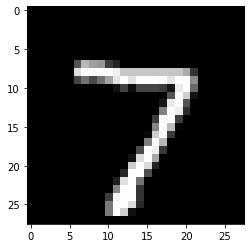

In [13]:
if __name__ == "__main__":
    main()